# 네이버 영화 리뷰 감성분류
- 데이터 : Naver sentiment movie corpus v1.0,  https://github.com/e9t/nsmc/

## 1. 데이터 가져오기

### 구글 코랩 한글 깨짐 현상 해결
- 한글폰트 설치
- 런타임 다시 시작

In [1]:
! sudo apt-get install -y fonts-nanum
! sudo fc-cache -fv
! rm ~/.cache/matplotlib -rf

import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic') 

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 34 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 1s (6,843 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletyp

### 라이브러리 임포트

In [2]:
import os
import urllib.request
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
%matplotlib inline

### 구글 드라이브 마운트

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 데이터 저장 디렉토리 생성

In [4]:
DATA_PATH = '/content/drive/MyDrive/nlpdata/nsmc/'

if not os.path.exists(DATA_PATH):
    os.makedirs(DATA_PATH)

### 데이터 가져오기
 - cf : `! wget https://github.com/e9t/nsmc/raw/master/ratings.txt`


In [5]:
file = ['ratings.txt', 'ratings_train.txt', 'ratings_test.txt']
for f in file:
    URL = "https://github.com/e9t/nsmc/raw/master/" + f
    FILE_NAME = DATA_PATH + f
    urllib.request.urlretrieve(URL, filename=FILE_NAME)

In [6]:
# ! pip install wget
# import wget
# import shutil

# file = ['ratings.txt', 'ratings_train.txt', 'ratings_test.txt']
# for f in file:
#     url = "https://github.com/e9t/nsmc/raw/master/" + f
#     wget.download(url)
#     shutil.move(f, DATA_PATH + f)

In [7]:
for file in os.listdir(DATA_PATH):
    if 'txt' in file :
        print(f'{file : <20} {os.path.getsize(DATA_PATH + file) / 1000000: ,.2f} MB')

ratings_train.txt     14.63 MB
ratings.txt           19.52 MB
ratings_test.txt      4.89 MB


## 2. 데이터 로드

In [8]:
train_data = pd.read_csv(DATA_PATH + 'ratings_train.txt', header = 0, delimiter = '\t', quoting = 3)
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


## 3. 데이터 분석
- 데이터의 개수
- 리뷰의 문자 길이 분포
- 많이 사용된 단어
- 긍정, 부정 데이터(label)의 분포
- 리뷰의 단어 개수 분포

### 데이터 개수

In [9]:
print(f'Train 데이터 개수: {len(train_data):,}')

Train 데이터 개수: 150,000


In [10]:
train_length = train_data['document'].astype(str).apply(len)

In [11]:
train_length.head()

0    19
1    33
2    17
3    29
4    61
Name: document, dtype: int64

### 리뷰의 문자 길이 분포

Text(0, 0.5, '리뷰 갯수')

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47532 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48624 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44600 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51060 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 55176 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/bac

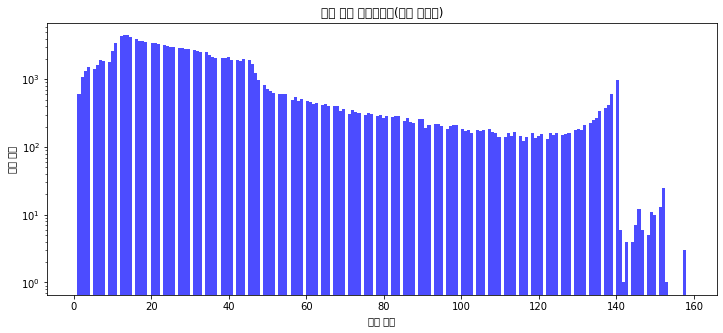

In [12]:
plt.figure(figsize=(12, 5))
plt.hist(train_length, bins=200, alpha=0.7, color= 'b', label='word')
plt.yscale('log', nonposy='clip')
plt.title('리뷰 길이 히스토그램(로그 스케일)')
plt.xlabel('리뷰 길이')
plt.ylabel('리뷰 갯수')

In [13]:
print(f'리뷰 길이 최대 값: {np.max(train_length)}')
print(f'리뷰 길이 최소 값: {np.min(train_length)}')
print(f'리뷰 길이 평균 값: {np.mean(train_length):.2f}')
print(f'리뷰 길이 표준편차: {np.std(train_length):.2f}')
print(f'리뷰 길이 중간값: {np.median(train_length)}')
print(f'리뷰 길이 제 1 사분위: {np.percentile(train_length, 25)}')
print(f'리뷰 길이 제 3 사분위: {np.percentile(train_length, 75)}')

리뷰 길이 최대 값: 158
리뷰 길이 최소 값: 1
리뷰 길이 평균 값: 35.24
리뷰 길이 표준편차: 29.58
리뷰 길이 중간값: 27.0
리뷰 길이 제 1 사분위: 16.0
리뷰 길이 제 3 사분위: 42.0


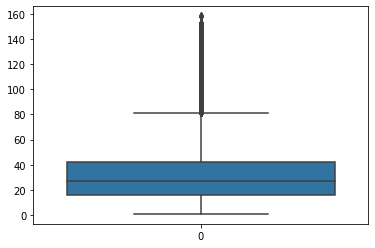

In [14]:
sns.boxplot(orient = "v", data=train_length)

In [15]:
train_review = [review for review in train_data['document'] if type(review) is str]

### 많이 사용된 단어 분석 - Word Cloud

(-0.5, 399.5, 199.5, -0.5)

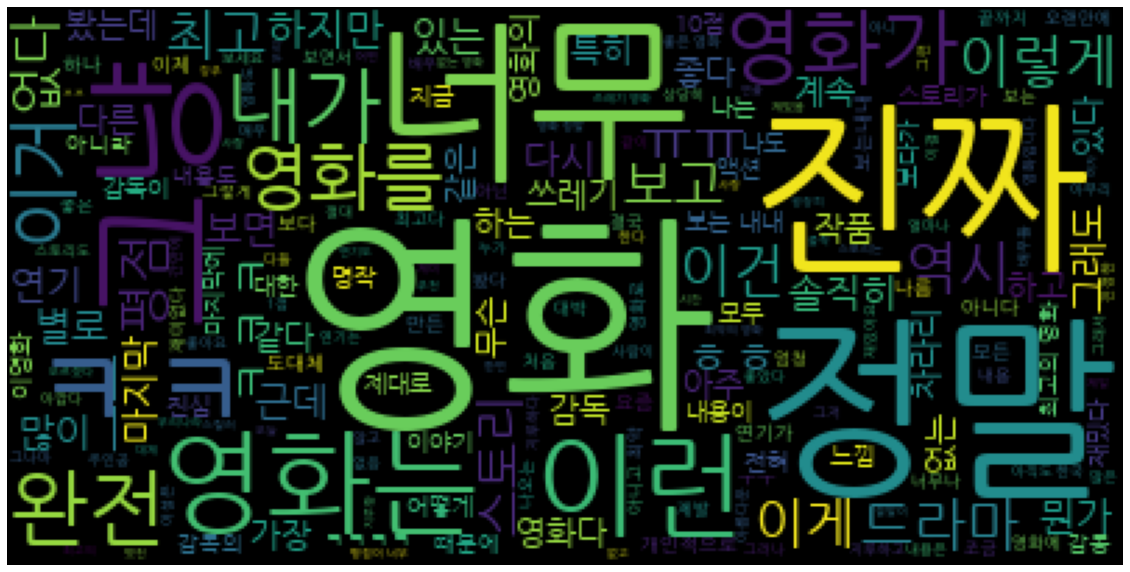

In [16]:
stopwords = ('그리고', 'ㅋ')
wordcloud = WordCloud(stopwords=stopwords, font_path='NanumGothic.ttf')
wordcloud = wordcloud.generate(' '.join(train_review))

plt.figure(figsize=(20, 15))
plt.imshow(wordcloud)
plt.axis('off')

### 긍정, 부정 데이터의 분포

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


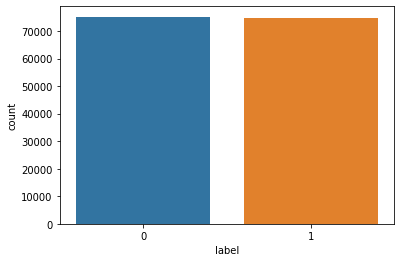

In [17]:
sns.countplot(train_data['label'])

### 리뷰의 단어 개수 분포

In [18]:
train_word_counts = train_data['document'].astype(str).apply(lambda x:len(x.split(' ')))

Text(0, 0.5, '개수')

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 45800 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50612 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44060 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 55176 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/bac

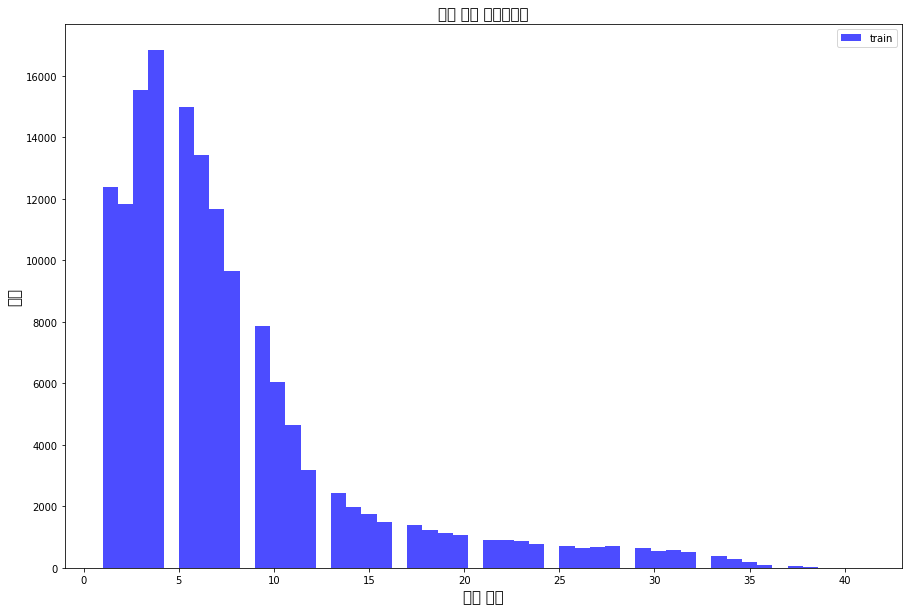

In [19]:
plt.figure(figsize=(12, 5))
plt.hist(train_word_counts, bins=50, alpha=0.7, color= 'b', label='train')
plt.title('단어 개수 히스토그램', fontsize=15)
# plt.yscale('log', nonposy='clip')
plt.legend()
plt.xlabel('단어 개수', fontsize=15)
plt.ylabel('개수', fontsize=15)

In [20]:
print(f'리뷰 단어 개수 최대 값: {np.max(train_word_counts)}')
print(f'리뷰 단어 개수 최소 값: {np.min(train_word_counts)}')
print(f'리뷰 단어 개수 평균 값: {np.mean(train_word_counts):.2f}')
print(f'리뷰 단어 개수 표준편차: {np.std(train_word_counts):.2f}')
print(f'리뷰 단어 개수 중간 값: {np.median(train_word_counts)}')
print(f'리뷰 단어 개수 제 1 사분위: {np.percentile(train_word_counts, 25)}')
print(f'리뷰 단어 개수 제 3 사분위: {np.percentile(train_word_counts, 75)}')

리뷰 단어 개수 최대 값: 41
리뷰 단어 개수 최소 값: 1
리뷰 단어 개수 평균 값: 7.58
리뷰 단어 개수 표준편차: 6.51
리뷰 단어 개수 중간 값: 6.0
리뷰 단어 개수 제 1 사분위: 3.0
리뷰 단어 개수 제 3 사분위: 9.0


## 3. 데이터 전처리

In [21]:
!pip install konlpy

     |████████████████████████████████| 19.4MB 53.2MB/s 
     |████████████████████████████████| 460kB 47.8MB/s 
     |████████████████████████████████| 92kB 11.1MB/s 
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


In [22]:
import re
import json
import numpy as np
import pandas as pd

from konlpy.tag import Okt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [23]:
train_data = pd.read_csv(DATA_PATH + 'ratings_train.txt', header=0, delimiter='\t', quoting=3 )
test_data  = pd.read_csv(DATA_PATH + 'ratings_test.txt', header=0, delimiter='\t', quoting=3 )
print(train_data.head())

         id                                           document  label
0   9976970                                아 더빙.. 진짜 짜증나네요 목소리      0
1   3819312                  흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나      1
2  10265843                                  너무재밓었다그래서보는것을추천한다      0
3   9045019                      교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정      0
4   6483659  사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...      1


In [24]:
review_text = re.sub("[^가-힣ㄱ-ㅎㅏ-ㅣ\\s]", "", train_data['document'][0]) 
print(review_text)

아 더빙 진짜 짜증나네요 목소리


### 전처리 함수
- 한글 및 공백을 제외한 문자 모두 제거
- 형태소 분리
- 불용어 제거

In [25]:
def preprocessing(data, okt, stop_words = []):
    k_data = re.sub("[^가-힣ㄱ-ㅎㅏ-ㅣ\\s]", "", data)
    m_data = okt.morphs(k_data, stem=True)
    if stop_words:
        p_data = [token for token in m_data if not token in stop_words]
    return p_data

### 데이터 전처리

In [27]:
stop_words = [ '은', '는', '이', '가', '하', '아', '것', '들','의', '있', '되', '수', '보', '주', '등', '한']
okt = Okt()

clean_train_review = []
for review in train_data['document']:
    if type(review) == str:
        p_data  = preprocessing(review, okt, stop_words=stop_words)
        clean_train_review.append(p_data)
    else:
        clean_train_review.append([])

clean_test_review = []
for review in test_data['document']:
    if type(review) == str:
        p_data = preprocessing(review, okt, stop_words=stop_words)
        clean_test_review.append(p_data)
    else:
        clean_test_review.append([])

### 인덱스 벡터 생성

In [28]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(clean_train_review)
train_sequences = tokenizer.texts_to_sequences(clean_train_review)
test_sequences = tokenizer.texts_to_sequences(clean_test_review)

vocab = tokenizer.word_index 
vocab["<PAD>"] = 0

### 인덱스 벡터 패딩 처리

In [29]:
MAX_SEQUENCE_LENGTH = 8

train_inputs = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
train_labels = np.array(train_data['label'])

test_inputs = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
test_labels = np.array(test_data['label'])

### 전처리 데이터 저장

In [30]:
TRAIN_INPUT_DATA = 'train_input.npy'
TRAIN_LABEL_DATA = 'train_label.npy'
TEST_INPUT_DATA = 'test_input.npy'
TEST_LABEL_DATA = 'test_label.npy'
DATA_CONFIGS = 'data_configs.json'

data_configs = {}

data_configs['vocab'] = vocab
data_configs['vocab_size'] = len(vocab)

np.save(open(DATA_PATH + TRAIN_INPUT_DATA, 'wb'), train_inputs)
np.save(open(DATA_PATH + TRAIN_LABEL_DATA, 'wb'), train_labels)

# 전처리 된 테스트 데이터를 넘파이로 저장
np.save(open(DATA_PATH + TEST_INPUT_DATA, 'wb'), test_inputs)
np.save(open(DATA_PATH + TEST_LABEL_DATA, 'wb'), test_labels)

# 데이터 사전을 json으로 저장
json.dump(data_configs, open(DATA_PATH + DATA_CONFIGS, 'w'), ensure_ascii=False)